# nanoAhaMoment: Single File R1-Zero Training

## Installation Requirements

Install the required packages:

```txt
# Core dependencies
torch==2.9.1

# Deep learning frameworks
transformers>=4.57.0
datasets>=4.5.0
deepspeed>=0.18.0
accelerate

# Flash Attention for A100
flash-attn

# vLLM for inference
vllm>=0.14.1

# Training and logging (optional - see USE_WANDB flag)
wandb
tqdm

# Standard scientific computing
numpy
```

In [ ]:
!pip install torch==2.9.1
!pip install transformers datasets deepspeed accelerate vllm tqdm numpy
# Optional: install wandb if you want to use it (set USE_WANDB=True)
# !pip install wandb
!pip install flash-attn --no-build-isolation

In [4]:
import os
from pathlib import Path

# Use /workspace for persistent storage on RunPod (network volume).
# Falls back to current directory for local development.
WORKSPACE = Path("/workspace") if Path("/workspace").exists() else Path.cwd()
SCRATCH = WORKSPACE / "scratch"
SCRATCH.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"] = str(SCRATCH / "hf_home")

In [2]:
from __future__ import annotations

import gc
import re
import time
import sys
from typing import Any, Dict, List, Tuple, Union, TYPE_CHECKING

import torch

import deepspeed
import numpy as np
from datasets import load_dataset
from deepspeed import DeepSpeedEngine
from tqdm import trange
from transformers import AutoModelForCausalLM, AutoTokenizer

# Direct imports to avoid vLLM lazy import issues
from vllm.entrypoints.llm import LLM
from vllm.sampling_params import SamplingParams

if TYPE_CHECKING:
    from transformers import PreTrainedModel

try:
    import wandb
except ImportError:
    wandb = None
    print("wandb not installed. Set USE_WANDB=False to run without it.")

from utils import (
    compute_token_log_probs,
    dump_episodes,
    evaluate_on_test_set,
    find_free_port,
    find_last_checkpoint,
    prepare_model_inputs,
    load_model_into_vllm
)

# Needed to stop DeepSpeed from complaining
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = str(find_free_port())
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Must be set BEFORE creating the vLLM engine so the engine core subprocess
# inherits it and can deserialize callables sent via apply_model / collective_rpc.
os.environ["VLLM_ALLOW_INSECURE_SERIALIZATION"] = "1"

/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


## Hyperparameters

In [5]:
# Model configuration
MODEL_NAME = "Qwen/Qwen2.5-3B"
MODEL_CHAT_NAME = MODEL_NAME + "-Instruct"

# Dataset configuration
DATASET_NAME = "Jiayi-Pan/Countdown-Tasks-3to4"

# Total number of training iterations
NUM_ITERATIONS = 1000
# Number of episodes to collect per iteration for training
EPISODES_PER_ITERATION = 64
# Number of responses to generate for each input prompt (i.e. group size in GRPO)
GENERATIONS_PER_SAMPLE = 4
# Controls how much the policy can deviate from the reference model
KL_COEFFICIENT = 0.001

# Training hyperparameters
# Batch size for each GPU device during training
PER_DEVICE_BATCH_SIZE = 4
# Learning rate for model updates
LEARNING_RATE = 1e-6

# Sampling parameters
# Maximum number of tokens to generate in each response
MAX_RESPONSE_TOKENS = 1024
# Controls randomness in generation (higher = more random)
TEMPERATURE = 1.0
# Nucleus sampling parameter (1.0 = disabled)
TOP_P = 1.0
# Top-k sampling parameter (-1 = disabled)
TOP_K = -1  # no top k

# Logging configuration
USE_WANDB = False  # Set to True to enable wandb logging

# DeepSpeed configuration
# DeepSpeed config for the policy model
deepspeed_config = {
    "bf16": {"enabled": True},
    "zero_optimization": {"stage": 2, "overlap_comm": False},
    "train_batch_size": EPISODES_PER_ITERATION,
    "train_micro_batch_size_per_gpu": PER_DEVICE_BATCH_SIZE,
    "gradient_accumulation_steps": EPISODES_PER_ITERATION // PER_DEVICE_BATCH_SIZE,
    "gradient_clipping": 1.0,
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": LEARNING_RATE,
            "betas": (0.9, 0.999),
            "eps": 1e-8,
            "weight_decay": 0.0,
            "torch_adam": True,
        },
    },
}
# DeepSpeed config for the reference model
ref_deepspeed_config = {
    "bf16": {"enabled": True},
    # Note that we don't train the reference model
    # These are just for compatibility with DeepSpeed.
    "train_batch_size": EPISODES_PER_ITERATION,
    "train_micro_batch_size_per_gpu": PER_DEVICE_BATCH_SIZE,
    "gradient_accumulation_steps": EPISODES_PER_ITERATION // PER_DEVICE_BATCH_SIZE,
}

RUN_NAME = "r1-zero"
EXP_DIR = SCRATCH / "deepseek_r1z_hackathon" / RUN_NAME
EXP_DIR.mkdir(parents=True, exist_ok=True)
print(f"Logs and Checkpoints will be saved to: {EXP_DIR}")

Logs and Checkpoints will be saved to: /workspace/scratch/deepseek_r1z_hackathon/r1-zero


## Generating the training prompts

In [4]:
SYSTEM_MESSAGE = (
    "You are a helpful assistant. You first think about the reasoning process in the mind "
    "and then provide the user with the answer."
)
PROMPT_TEMPLATE = (
    "Using the numbers {numbers}, create an equation that equals {target}. "
    "You can use basic arithmetic operations (+, -, *, /) and each number can only be used once. "
    "Show your work in <think> </think> tags. And return the final equation and answer in "
    "<answer> </answer> tags, for example <answer>(1 + 2) / (3 * 5)</answer>."
)

In [5]:
# Load and process dataset
def preprocess_example(example: Dict[str, Any]):
    numbers: List[int] = example["nums"]
    target: int = example["target"]

    prefix = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": PROMPT_TEMPLATE.format(numbers=numbers, target=target)},
        {"role": "assistant", "content": "Let me solve this step by step.\n<think>"},
    ]
    input_ids = tokenizer.apply_chat_template(
        prefix, tokenize=True, continue_final_message=True
    )
    prompt = tokenizer.decode(
        input_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False
    )
    return {"prompt": prompt, "input_ids": input_ids}

# Note that the base model and "instruct" model have different eos token. 
# Here we make sure to use the correct one.
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHAT_NAME)
EOS_TOKEN_ID = AutoTokenizer.from_pretrained(MODEL_NAME).eos_token_id
EOS_TOKEN = tokenizer.convert_ids_to_tokens(EOS_TOKEN_ID)

dataset = load_dataset(DATASET_NAME, split="train")
dataset = dataset.map(preprocess_example, num_proc=6)

# Split dataset
train_test_split = dataset.train_test_split(test_size=500, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

len(train_dataset), len(test_dataset)

(489864, 500)

## Reward Function

In [6]:
def format_reward_func(completion: str) -> float:
    """Check if output follows <think>...</think>\n<answer>...</answer> format."""
    allowed_pattern = r"^[\d+\-*/().\s]+$"

    try:
        completion = "<think>" + completion
        if completion.endswith(EOS_TOKEN):
            completion = completion[:-len(EOS_TOKEN)]

        regex = r"^<think>([^<]*(?:<(?!/?think>)[^<]*)*)<\/think>\n<answer>([\s\S]*?)<\/answer>$"
        match = re.search(regex, completion, re.DOTALL)

        if match is None or len(match.groups()) != 2:
            return 0.0
        else:
            answer_content = match.group(2).strip()
            if not re.match(allowed_pattern, answer_content):
                return 0.5
            else:
                return 1.0
    except Exception:
        return 0.0


def equation_reward_func(completion: str, nums: List[int], target: int) -> float:
    """Check if the equation in <answer> tags evaluates to the target using all numbers exactly once."""
    try:
        match = re.search(r"<answer>(.*?)<\/answer>", completion)
        if match is None:
            return 0.0

        equation = match.group(1).strip()
        used_numbers = [int(n) for n in re.findall(r"\d+", equation)]

        if sorted(used_numbers) != sorted(nums):
            return 0.0

        allowed_pattern = r"^[\d+\-*/().\s]+$"
        if not re.match(allowed_pattern, equation):
            return 0.0

        result = eval(equation, {"__builtins__": None}, {})
        if abs(float(result) - float(target)) < 1e-5:
            return 1.0
        else:
            return 0.0
    except Exception:
        return 0.0
    

def compute_reward(completion: str, sample: Dict[str, Any]) -> Tuple[float, Dict[str, float]]:
    nums = sample["nums"]
    target = sample["target"]

    format_reward = format_reward_func(completion)
    equation_reward = equation_reward_func(completion=completion, nums=nums, target=target)

    reward = format_reward + equation_reward
    metrics = {
        "format_reward": format_reward,
        "equation_reward": equation_reward,
    }   

    return reward, metrics

## Episode Generation

In [7]:
def create_training_episodes(
    samples: List[Dict[str, Any]],
    all_generations: List[List[int]],
    all_finish_reasons: List[str],
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """Process generations into training episodes with GRPO advantages."""
    assert len(all_generations) == len(all_finish_reasons)
    assert len(all_generations) == len(samples) * GENERATIONS_PER_SAMPLE

    groups = [
        list(range(i, i + GENERATIONS_PER_SAMPLE))
        for i in range(0, len(all_generations), GENERATIONS_PER_SAMPLE)
    ]

    all_query_token_ids, all_responses_token_ids, all_advantages = [], [], []

    stats = {
        "response_lengths": [],
        "rewards": [],
        "non_stop_rate": [],
    }

    for sample, group_indices in zip(samples, groups):
        finish_reasons = [all_finish_reasons[i] for i in group_indices]
        response_token_ids = [all_generations[i] for i in group_indices]
        responses = tokenizer.batch_decode(response_token_ids, skip_special_tokens=False)

        rewards_and_metrics = [compute_reward(resp, sample) for resp in responses]
        rewards, reward_metrics = zip(*rewards_and_metrics)

        # GRPO advantage: normalize rewards within the group
        rewards = np.array(rewards)
        response_advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)
        
        # Assign same advantage to all tokens in each response
        advantages = [
            [resp_adv] * len(resp) 
            for resp_adv, resp in zip(response_advantages, response_token_ids)
        ]

        all_query_token_ids.extend([sample["input_ids"]] * GENERATIONS_PER_SAMPLE)
        all_responses_token_ids.extend(response_token_ids)
        all_advantages.extend(advantages)

        stats["rewards"].extend(rewards)
        stats["non_stop_rate"].extend([fr != "stop" for fr in finish_reasons])
        stats["response_lengths"].extend([len(ids) for ids in response_token_ids])
        for rm in reward_metrics:
            for k, v in rm.items():
                stats.setdefault(f"reward_metrics/{k}", []).append(v)

    episodes = {
        "all_query_token_ids": all_query_token_ids,
        "all_response_token_ids": all_responses_token_ids,
        "all_advantages": all_advantages,
    }

    return episodes, stats

## Policy Gradient Loss

In [8]:
def compute_pg_loss(
    policy_model: Union[DeepSpeedEngine, PreTrainedModel],
    reference_model: Union[DeepSpeedEngine, PreTrainedModel],
    batch: Dict[str, torch.Tensor],
    total_response_len: int,
) -> Tuple[torch.Tensor, Dict[str, float]]:
    """Compute policy gradient loss with KL penalty between policy and reference models."""
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    advantages = batch["advantages"]

    model_inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "labels_mask": batch["labels_mask"],
    }

    labels_mask = (labels[..., 1:] != -100).float()

    with torch.no_grad():
        ref_logps = compute_token_log_probs(reference_model, model_inputs, TEMPERATURE)

    logps = compute_token_log_probs(policy_model, model_inputs, TEMPERATURE)

    # KL penalty (k3 estimator)
    kl_penalty = torch.exp(ref_logps - logps) - (ref_logps - logps) - 1
    kl_penalty = kl_penalty * labels_mask

    entropy = -logps.sum() / labels_mask.sum()

    # Policy gradient loss: -log_prob * advantage
    policy_loss = -logps * advantages[..., 1:]
    policy_loss = policy_loss * labels_mask

    loss = (policy_loss + KL_COEFFICIENT * kl_penalty).sum() / total_response_len

    metrics = {
        "policy_loss": policy_loss.sum().item() / total_response_len,
        "kl_penalty": kl_penalty.sum().item() / total_response_len,
        "entropy": entropy.item() / total_response_len,
    }

    return loss, metrics

## Training

In [9]:
# Initialize main and reference models
policy_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map=0,
)
reference_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map=0,
)
policy_model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})


# Initialize DeepSpeed engines
policy_model, *_ = deepspeed.initialize(
    model=policy_model,
    config=deepspeed_config,
    model_parameters=policy_model.parameters(),
)
reference_model, *_ = deepspeed.initialize(
    model=reference_model,
    config=ref_deepspeed_config,
)

reference_model.module.cpu()

# Free up GPU memory before initializing vLLM
gc.collect()
torch.cuda.empty_cache()
time.sleep(2)

############################################
# Initialize vLLM (Inference) engine
############################################

print("Initializing vLLM inference engine...")
inference_engine = LLM(
    model=MODEL_NAME,
    skip_tokenizer_init=False,
    gpu_memory_utilization=0.15,  # Reduced from 0.2 to leave more room
    enable_prefix_caching=True,
    swap_space=2,  # Increased swap space
    scheduling_policy="fcfs",
    dtype="bfloat16",  # Use string instead of torch.bfloat16
    max_model_len=2048,
    enable_sleep_mode=True,
)
print("vLLM inference engine initialized successfully")

# Wandb for logging
if USE_WANDB:
    if wandb is None:
        raise ImportError("wandb is not installed. Run: pip install wandb")
    wandb.init(
        project="r1-aha-moment",
        name=RUN_NAME,
        config={
            "model_name": MODEL_NAME,
            "learning_rate": LEARNING_RATE,
            "num_iterations": NUM_ITERATIONS,
            "episodes_per_iteration": EPISODES_PER_ITERATION,
            "rollouts_per_episode": GENERATIONS_PER_SAMPLE,
            "kl_coefficient": KL_COEFFICIENT,
            "temperature": TEMPERATURE,
        },
    )
    print("Wandb logging enabled")
else:
    print("Wandb logging disabled")

# Load checkpoint if it exists
begin_iter = 0
ckpt_path, ckpt_iter = find_last_checkpoint(EXP_DIR)
if ckpt_path is not None:
    print(f"Resuming from checkpoint {ckpt_path} at iteration {ckpt_iter}")
    out = policy_model.load_checkpoint(ckpt_path / "deepspeed")
    if out is None:
        raise RuntimeError(f"Failed to load checkpoint {ckpt_path}")
    begin_iter = ckpt_iter + 1
    load_model_into_vllm(policy_model, inference_engine)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Before initializing optimizer states
MA 22.99 GB         Max_MA 28.74 GB         CA 34.49 GB         Max_CA 34 GB 
CPU Virtual Memory:  used = 47.06 GB, percent = 5.0%
After initializing optimizer states
MA 22.99 GB         Max_MA 34.49 GB         CA 45.99 GB         Max_CA 46 GB 
CPU Virtual Memory:  used = 46.91 GB, percent = 5.0%
After initializing ZeRO optimizer
MA 22.99 GB         Max_MA 22.99 GB         CA 45.99 GB         Max_CA 46 GB 
CPU Virtual Memory:  used = 46.99 GB, percent = 5.0%
begin bf16_optimizer
MA 22.99 GB         Max_MA 22.99 GB         CA 45.99 GB         Max_CA 46 GB 
CPU Virtual Memory:  used = 47.08 GB, percent = 5.0%
end bf16_ optimizer
MA 22.99 GB         Max_MA 22.99 GB         CA 45.99 GB         Max_CA 46 GB 
CPU Virtual Memory:  used = 47.02 GB, percent = 5.0%
Initializing vLLM inference engine...
INFO 02-17 22:05:35 [utils.py:261] non-default args: {'dtype': 'bfloat16', 'max_model_len': 2048, 'enable_prefix_caching': True, 'swap_space': 2, 'gpu_memory_u

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.96it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.93it/s]
(EngineCore_DP0 pid=13850) 


(EngineCore_DP0 pid=13850) INFO 02-17 22:05:46 [default_loader.py:291] Loading weights took 1.12 seconds
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:46 [gpu_model_runner.py:4130] Model loading took 5.79 GiB memory and 2.046550 seconds
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:53 [backends.py:812] Using cache directory: /root/.cache/vllm/torch_compile_cache/f20a54b745/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:53 [backends.py:872] Dynamo bytecode transform time: 5.78 s
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:58 [backends.py:267] Directly load the compiled graph(s) for compile range (1, 8192) from the cache, took 0.925 s
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:58 [monitor.py:34] torch.compile takes 6.71 s in total
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:59 [gpu_worker.py:356] Available KV cache memory: 4.64 GiB
(EngineCore_DP0 pid=13850) INFO 02-17 22:05:59 [kv_cache_utils.py:1307] GPU KV cache size: 135,136 tokens
(EngineCore_DP0

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:02<00:00, 18.51it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:01<00:00, 20.45it/s]


(EngineCore_DP0 pid=13850) INFO 02-17 22:06:05 [gpu_model_runner.py:5063] Graph capturing finished in 5 secs, took 0.57 GiB
(EngineCore_DP0 pid=13850) INFO 02-17 22:06:05 [core.py:272] init engine (profile, create kv cache, warmup model) took 18.28 seconds
(EngineCore_DP0 pid=13850) WARNING 02-17 22:06:06 [serial_utils.py:57] Allowing insecure serialization using pickle due to VLLM_ALLOW_INSECURE_SERIALIZATION=1
(EngineCore_DP0 pid=13850) INFO 02-17 22:06:06 [vllm.py:624] Asynchronous scheduling is enabled.
INFO 02-17 22:06:06 [llm.py:343] Supported tasks: ('generate',)
vLLM inference engine initialized successfully
Wandb logging disabled


In [ ]:
for iteration in trange(begin_iter, NUM_ITERATIONS):
    print(f"Iteration {iteration}/{NUM_ITERATIONS}")

    metrics = {}

    #########################################################
    # Evaluation
    #########################################################

    eval_stats = None
    if iteration % 25 == 0:
        print("Evaluating on eval set...")
        eval_episodes, eval_stats = evaluate_on_test_set(
            inference_engine=inference_engine,
            test_dataset=test_dataset,
            tokenizer=tokenizer,
            eos_token=EOS_TOKEN,
            eval_sampling_params=SamplingParams(
                temperature=0.3,
                max_tokens=1024,
                n=1,
                detokenize=False,
                stop_token_ids=[EOS_TOKEN_ID],
            ),
            reward_func=lambda completion, sample: compute_reward(
                completion, sample
            ),
        )
        eval_episode_table = dump_episodes(
            episodes=eval_episodes,
            episodes_stats=eval_stats,
            exp_dir=EXP_DIR,
            tokenizer=tokenizer,
            iteration=iteration,
            is_eval=True,
        )
        if USE_WANDB:
            wandb.log({"eval/episodes": eval_episode_table, "iteration": iteration})


    #########################################################
    # Generate Episodes
    #########################################################

    # Sample training batch
    num_samples = EPISODES_PER_ITERATION // GENERATIONS_PER_SAMPLE
    indices = np.random.choice(
        len(train_dataset), size=num_samples, replace=False
    )
    samples = train_dataset.select(indices)

    # Sample responses
    outputs = inference_engine.generate(
        prompts=[{"prompt_token_ids": ids} for ids in samples["input_ids"]],
        sampling_params=SamplingParams(
            n=GENERATIONS_PER_SAMPLE,
            temperature=TEMPERATURE,
            top_p=TOP_P,
            top_k=TOP_K,
            max_tokens=MAX_RESPONSE_TOKENS,
            detokenize=False,
            stop_token_ids=[EOS_TOKEN_ID],
        )
    )
    all_generations = [list(g.token_ids) for out in outputs for g in out.outputs]
    all_finish_reasons = [g.finish_reason for out in outputs for g in out.outputs]
    inference_engine.sleep(1)

    print(f"Generated {len(all_generations)} responses")
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(1)

    # Process responses and calculate rewards
    episodes, episodes_stats = create_training_episodes(
        samples,
        all_generations,
        all_finish_reasons,
    )
    for k, v in episodes_stats.items():
        metrics.setdefault(k, []).extend(v)

    episode_table = dump_episodes(
        episodes=episodes,
        episodes_stats=episodes_stats,
        exp_dir=EXP_DIR,
        tokenizer=tokenizer,
        iteration=iteration,
    )

    #########################################################
    # Training
    #########################################################

    # Prepare training batch
    model_inputs = prepare_model_inputs(
        query_token_ids=episodes["all_query_token_ids"],
        response_token_ids=episodes["all_response_token_ids"],
        advantages=episodes["all_advantages"],
        device="cuda"
    )

    # Calculate losses and update model
    policy_model.train()
    reference_model.module.cuda()
    reference_model.eval()

    total_response_len = (model_inputs["labels"] != -100).sum().item()

    for i in trange(0, EPISODES_PER_ITERATION, PER_DEVICE_BATCH_SIZE, desc="Gradient Accumulation"):
        batch = {
            k: v[i : i + PER_DEVICE_BATCH_SIZE]
            for k, v in model_inputs.items()
        }

        # Compute policy gradient loss
        loss, loss_metrics = compute_pg_loss(
            policy_model=policy_model,
            reference_model=reference_model,
            batch=batch,
            total_response_len=total_response_len,
        )

        # Track metrics
        metrics.setdefault("loss", []).append(loss.item())
        grad_norm = policy_model.get_global_grad_norm()
        if grad_norm is not None:
            grad_norm = grad_norm.item()
        metrics.setdefault("grad_norm", []).append(grad_norm)
        for k, v in loss_metrics.items():
            metrics.setdefault(k, []).append(v.item() if isinstance(v, torch.Tensor) else v)

        # Backpropagation and optimization step
        policy_model.backward(loss, scale_wrt_gas=False)
        
        # Free memory
        del loss, loss_metrics
        if policy_model.is_gradient_accumulation_boundary():
            reference_model.module.cpu()

        policy_model.step()

    #########################################################
    # Update inference engine weights
    #########################################################
    
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(1)

    inference_engine.wake_up()
    load_model_into_vllm(policy_model, inference_engine)

    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(1)


    #########################################################
    # Log metrics
    #########################################################

    train_metrics = {
        k: np.mean(v) for k, v in metrics.items() if None not in v
    }
    train_metrics["learning_rate"] = policy_model.get_lr()[0]
    logs = {
        "iteration": iteration,
        f"episodes/iter_{iteration:06d}": episode_table,
        **{f"train/{k}": v for k, v in train_metrics.items()},
    }
    if eval_stats is not None:
        eval_metrics = {k: np.mean(v) for k, v in eval_stats.items() if None not in v}
        logs.update({f"eval/{k}": v for k, v in eval_metrics.items()})
    
    if USE_WANDB:
        wandb.log(logs)

    selected_keys = [
        "train/kl_penalty",
        "train/rewards",
        "train/reward_metrics/format_reward",
        "train/reward_metrics/equation_reward",
        "eval/rewards",
        "eval/reward_metrics/format_reward",
        "eval/reward_metrics/equation_reward",
    ]
    selected_metrics = {k: logs[k] for k in selected_keys if k in logs}
    print(f"KEY METRICS: {selected_metrics}")

    if iteration % 50 == 0 and iteration != 0:
        policy_model.save_checkpoint(
            str(EXP_DIR / "checkpoints" / f"ckpt_{iteration:06d}" / "deepspeed")
        )

# Export final model in HuggingFace format for easy inference
policy_model.module.save_pretrained(
    str(EXP_DIR / "checkpoints" / "final" / "hf_model")
)
tokenizer.save_pretrained(
    str(EXP_DIR / "checkpoints" / "final" / "hf_model")
)

## Results

In [18]:
import json
import re
import glob as glob_module
from pathlib import Path
from typing import Dict, List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def load_episodes(episode_dir: Path) -> Dict[int, List[Dict]]:
    """Load saved episode files recursively, keyed by iteration number."""
    episodes_by_iter = {}
    patterns = ["eps_*.json", "eps_*.js"]
    files = []
    for pattern in patterns:
        files.extend(sorted(episode_dir.rglob(pattern)))

    for fpath in sorted(set(files)):
        iteration = int(fpath.stem.split("_")[-1])
        with open(fpath) as f:
            episodes_by_iter[iteration] = json.load(f)
    return episodes_by_iter

train_episodes = load_episodes(EXP_DIR / "episodes")
eval_episodes = load_episodes(EXP_DIR / "eval_episodes")

print(f"Loaded train episodes from {len(train_episodes)} iterations")
print(f"Loaded eval episodes from {len(eval_episodes)} iterations")
print(f"Train iterations: {sorted(train_episodes.keys())[:5]} ... {sorted(train_episodes.keys())[-5:]}")
print(f"Eval iterations: {sorted(eval_episodes.keys())[:5]} ... {sorted(eval_episodes.keys())[-5:]}")

Loaded train episodes from 68 iterations
Loaded eval episodes from 3 iterations
Train iterations: [0, 1, 2, 3, 4] ... [63, 64, 65, 66, 67]
Eval iterations: [0, 25, 50] ... [0, 25, 50]


### How did performance increase on the countdown task?

We track two reward components across training:
- **Format reward** (0 or 0.5 or 1.0): Does the model produce valid `<think>...</think>\n<answer>...</answer>` formatting?
- **Equation reward** (0 or 1.0): Does the equation in the answer actually evaluate to the target using all numbers exactly once?

The total reward is the sum of both (max 2.0). We plot these over training iterations for both the training rollouts and the held-out eval set.

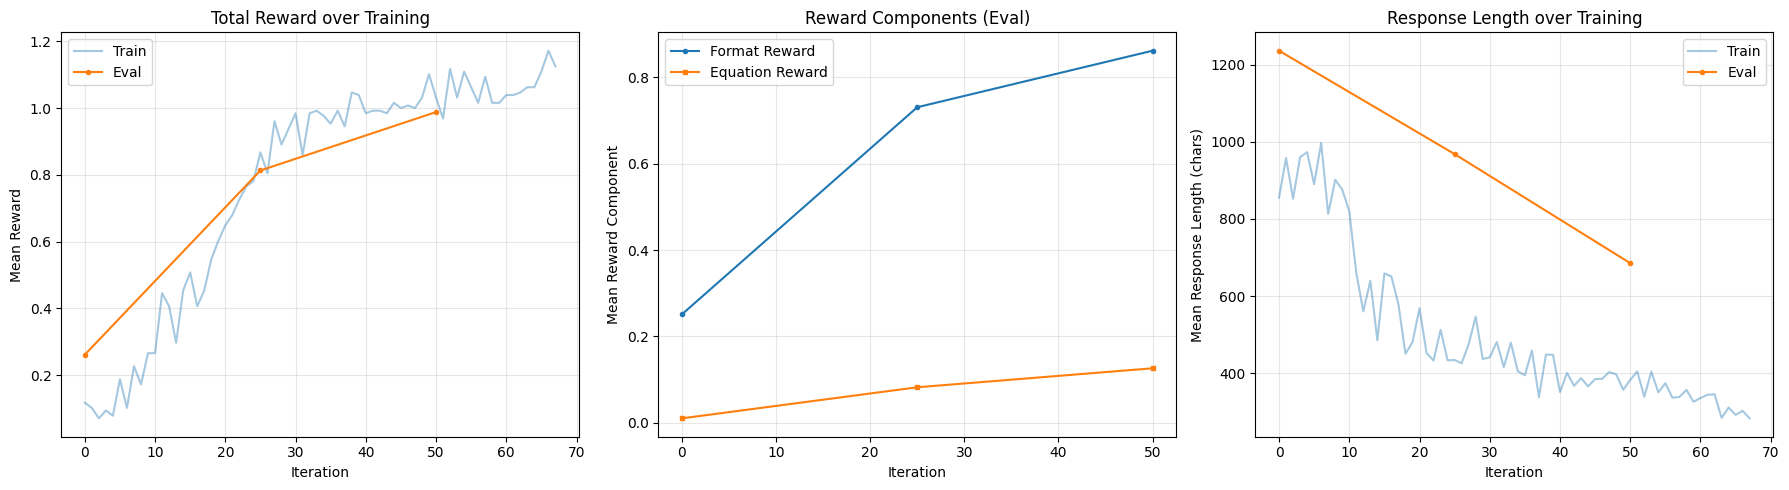


Metric                    Iter 0          Iter 50         Change         
----------------------------------------------------------------------
mean_reward               0.2610          0.9880          +0.7270
format_rate               0.2510          0.8620          +0.6110
equation_rate             0.0100          0.1260          +0.1160


In [19]:
def compute_episode_metrics(episodes_by_iter: Dict[int, List[Dict]]) -> Dict[str, List]:
    """Compute per-iteration aggregate metrics from saved episodes."""
    def format_reward_from_saved(completion: str) -> float:
        allowed_pattern = r"^[\d+\-*/().\s]+$"
        try:
            if completion.endswith("<|endoftext|>"):
                completion = completion[:-len("<|endoftext|>")]
            completion = "<think>" + completion
            regex = r"^<think>([^<]*(?:<(?!/?think>)[^<]*)*)<\/think>\n<answer>([\s\S]*?)<\/answer>$"
            match = re.search(regex, completion, re.DOTALL)
            if match is None or len(match.groups()) != 2:
                return 0.0
            answer_content = match.group(2).strip()
            return 0.5 if not re.match(allowed_pattern, answer_content) else 1.0
        except Exception:
            return 0.0

    def equation_reward_from_saved(completion: str, nums: List[int], target: int) -> float:
        try:
            match = re.search(r"<answer>(.*?)<\/answer>", completion)
            if match is None:
                return 0.0
            equation = match.group(1).strip()
            used_numbers = [int(n) for n in re.findall(r"\d+", equation)]
            if sorted(used_numbers) != sorted(nums):
                return 0.0
            allowed_pattern = r"^[\d+\-*/().\s]+$"
            if not re.match(allowed_pattern, equation):
                return 0.0
            result = eval(equation, {"__builtins__": None}, {})
            return 1.0 if abs(float(result) - float(target)) < 1e-5 else 0.0
        except Exception:
            return 0.0

    iterations = sorted(episodes_by_iter.keys())
    metrics = {"iteration": [], "mean_reward": [], "format_rate": [], "equation_rate": [], "mean_response_len": []}

    for it in iterations:
        eps = episodes_by_iter[it]
        rewards = [e["reward"] for e in eps]
        responses = [e["response"] for e in eps]

        format_rewards = [format_reward_from_saved(r) for r in responses]
        equation_rewards = []
        for e in eps:
            query = e["query"]
            nums_match = re.search(r"numbers \[([^\]]+)\]", query)
            target_match = re.search(r"equals (\d+)", query)
            if nums_match and target_match:
                nums = [int(x.strip()) for x in nums_match.group(1).split(",")]
                target = int(target_match.group(1))
                equation_rewards.append(equation_reward_from_saved(e["response"], nums, target))
            else:
                equation_rewards.append(0.0)

        metrics["iteration"].append(it)
        metrics["mean_reward"].append(np.mean(rewards))
        metrics["format_rate"].append(np.mean(format_rewards))
        metrics["equation_rate"].append(np.mean(equation_rewards))
        metrics["mean_response_len"].append(np.mean([len(r) for r in responses]))

    return metrics

train_metrics = compute_episode_metrics(train_episodes)
eval_metrics = compute_episode_metrics(eval_episodes)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total reward
axes[0].plot(train_metrics["iteration"], train_metrics["mean_reward"], alpha=0.4, label="Train")
if eval_metrics["iteration"]:
    axes[0].plot(eval_metrics["iteration"], eval_metrics["mean_reward"], "o-", label="Eval", markersize=3)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Mean Reward")
axes[0].set_title("Total Reward over Training")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Format reward vs Equation reward (eval)
source = eval_metrics if eval_metrics["iteration"] else train_metrics
axes[1].plot(source["iteration"], source["format_rate"], "o-", label="Format Reward", markersize=3)
axes[1].plot(source["iteration"], source["equation_rate"], "s-", label="Equation Reward", markersize=3)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Mean Reward Component")
axes[1].set_title("Reward Components (Eval)" if eval_metrics["iteration"] else "Reward Components (Train)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Response length
axes[2].plot(train_metrics["iteration"], train_metrics["mean_response_len"], alpha=0.4, label="Train")
if eval_metrics["iteration"]:
    axes[2].plot(eval_metrics["iteration"], eval_metrics["mean_response_len"], "o-", label="Eval", markersize=3)
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Mean Response Length (chars)")
axes[2].set_title("Response Length over Training")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
if eval_metrics["iteration"]:
    first_iter, last_iter = eval_metrics["iteration"][0], eval_metrics["iteration"][-1]
    print(f"\n{'Metric':<25} {'Iter ' + str(first_iter):<15} {'Iter ' + str(last_iter):<15} {'Change':<15}")
    print("-" * 70)
    for key in ["mean_reward", "format_rate", "equation_rate"]:
        v0, v1 = eval_metrics[key][0], eval_metrics[key][-1]
        print(f"{key:<25} {v0:<15.4f} {v1:<15.4f} {v1-v0:+.4f}")

### Do we see things like the "aha moment" in the rollouts?

The "aha moment" from DeepSeek-R1 refers to the model spontaneously developing self-verification and correction behaviors during RL training -- without being explicitly taught to do so. We look for rollouts where the model:

- **Re-checks its own work** ("Wait, let me verify...", "Hmm, that doesn't work...")
- **Backtracks and tries again** ("No, that's wrong. Let me try a different approach...")
- **Self-verifies the answer** ("Let me check: 3 + 5 = 8. Yes, that's correct!")

We search through training rollouts for these patterns, focusing on high-reward episodes where the model got the right answer after showing signs of self-correction.

In [20]:
# Patterns that indicate self-correction / "aha moment" behaviors
AHA_PATTERNS = [
    r"[Ww]ait",
    r"[Hh]mm",
    r"[Aa]ctually",
    r"[Ll]et me (try|check|verify|reconsider|re-?evaluate|think)",
    r"[Nn]o,?\s*(that|this)('s|\s+is)?\s*(not|wrong|incorrect)",
    r"[Tt]hat('s|\s+is)?\s*(not|wrong|incorrect)",
    r"[Dd]oesn'?t\s*(work|equal|add up|give)",
    r"[Ll]et me re",
    r"[Ii] (made a mistake|was wrong|need to)",
    r"[Oo]n second thought",
    r"[Bb]ut wait",
    r"[Ss]o the answer",
]

def find_aha_episodes(episodes_by_iter: Dict[int, List[Dict]], min_reward: float = 1.5) -> List[Dict]:
    """Find episodes that show self-correction behavior AND got a high reward."""
    aha_episodes = []
    for iteration in sorted(episodes_by_iter.keys()):
        for ep in episodes_by_iter[iteration]:
            if ep["reward"] < min_reward:
                continue
            response = ep["response"]
            matched_patterns = []
            for pattern in AHA_PATTERNS:
                if re.search(pattern, response):
                    matched_patterns.append(pattern)
            if matched_patterns:
                aha_episodes.append({
                    "iteration": iteration,
                    "query": ep["query"],
                    "response": response,
                    "reward": ep["reward"],
                    "patterns": matched_patterns,
                    "num_patterns": len(matched_patterns),
                })
    return aha_episodes

aha_results = find_aha_episodes(train_episodes)
print(f"Found {len(aha_results)} high-reward episodes with self-correction patterns\n")

# Show when these patterns start appearing
if aha_results:
    aha_by_iter = {}
    for ep in aha_results:
        aha_by_iter.setdefault(ep["iteration"], []).append(ep)

    print("Iterations with aha-moment episodes (count):")
    for it in sorted(aha_by_iter.keys())[:20]:
        print(f"  Iter {it:>5d}: {len(aha_by_iter[it])} episodes")
    if len(aha_by_iter) > 20:
        print(f"  ... and {len(aha_by_iter) - 20} more iterations")

Found 9 high-reward episodes with self-correction patterns

Iterations with aha-moment episodes (count):
  Iter    19: 1 episodes
  Iter    20: 1 episodes
  Iter    26: 1 episodes
  Iter    33: 1 episodes
  Iter    46: 1 episodes
  Iter    52: 1 episodes
  Iter    60: 1 episodes
  Iter    61: 1 episodes
  Iter    64: 1 episodes


In [21]:
# Display the best "aha moment" examples (most self-correction patterns matched)
def display_rollout(ep: Dict, title: str = ""):
    """Render a single rollout with syntax highlighting for think/answer tags."""
    response = ep["response"]

    # Highlight self-correction phrases
    highlighted = response
    for pattern in AHA_PATTERNS:
        highlighted = re.sub(
            f"({pattern})",
            r'<span style="background-color: #fff3cd; font-weight: bold;">\1</span>',
            highlighted,
        )
    # Highlight tags
    highlighted = highlighted.replace("&lt;think&gt;", "<b>&lt;think&gt;</b>")
    highlighted = highlighted.replace("&lt;/think&gt;", "<b>&lt;/think&gt;</b>")
    highlighted = highlighted.replace("&lt;answer&gt;", "<b>&lt;answer&gt;</b>")
    highlighted = highlighted.replace("&lt;/answer&gt;", "<b>&lt;/answer&gt;</b>")

    html = f"""
    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; margin: 12px 0; background: #fafafa;">
        <div style="font-weight: bold; font-size: 14px; color: #333; margin-bottom: 8px;">
            {title} | Reward: {ep['reward']} | Patterns: {ep.get('num_patterns', '?')}
        </div>
        <div style="font-family: monospace; white-space: pre-wrap; font-size: 12px; line-height: 1.5; color: #555;">
{highlighted}
        </div>
    </div>
    """
    display(HTML(html))

if aha_results:
    # Sort by number of matched patterns (most "aha-like" first)
    best_aha = sorted(aha_results, key=lambda x: x["num_patterns"], reverse=True)

    print("Top 3 'aha moment' examples (most self-correction patterns):\n")
    for i, ep in enumerate(best_aha[:3]):
        display_rollout(ep, title=f"Example {i+1} (Iteration {ep['iteration']})")
else:
    print("No aha-moment episodes found. This may be expected if training hasn't run yet.")

Top 3 'aha moment' examples (most self-correction patterns):



### How do rollouts (model responses) compare from the beginning to the end of training?

We compare model responses from early vs. late training iterations side-by-side. This shows how the model evolves from producing unstructured or incorrect outputs to generating well-formatted, correct solutions with reasoning.

In [23]:
def display_rollout_simple(response: str, reward: float, title: str = ""):
    """Render a single rollout without pattern highlighting."""
    html = f"""
    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; margin: 8px 0; background: #fafafa;">
        <div style="font-weight: bold; font-size: 13px; color: #333; margin-bottom: 8px;">
            {title} | Reward: {reward}
        </div>
        <div style="font-family: monospace; white-space: pre-wrap; font-size: 12px; line-height: 1.5; color: #555;">
{response}
        </div>
    </div>
    """
    display(HTML(html))

# Use eval episodes if available (cleaner comparison), fall back to train
comparison_source = eval_episodes if eval_episodes else train_episodes
sorted_iters = sorted(comparison_source.keys())

if len(sorted_iters) >= 2:
    early_iter = sorted_iters[0]
    late_iter = sorted_iters[-1]
    early_eps = comparison_source[early_iter]
    late_eps = comparison_source[late_iter]

    NUM_EXAMPLES = 3

    for i in range(min(NUM_EXAMPLES, len(early_eps), len(late_eps))):
        display(HTML(f"<h4 style='margin-top: 24px;'>Comparison {i+1}</h4>"))
        display_rollout_simple(
            early_eps[i]["response"], early_eps[i]["reward"],
            title=f"EARLY (Iteration {early_iter})"
        )
        display_rollout_simple(
            late_eps[i]["response"], late_eps[i]["reward"],
            title=f"LATE (Iteration {late_iter})"
        )

    # Summary statistics
    early_rewards = [e["reward"] for e in early_eps]
    late_rewards = [e["reward"] for e in late_eps]
    early_lens = [len(e["response"]) for e in early_eps]
    late_lens = [len(e["response"]) for e in late_eps]

    print(f"\n{'='*60}")
    print(f"{'Statistic':<30} {'Iter ' + str(early_iter):<15} {'Iter ' + str(late_iter):<15}")
    print(f"{'='*60}")
    print(f"{'Mean reward':<30} {np.mean(early_rewards):<15.3f} {np.mean(late_rewards):<15.3f}")
    print(f"{'Reward > 0 (%)':<30} {100*np.mean([r > 0 for r in early_rewards]):<15.1f} {100*np.mean([r > 0 for r in late_rewards]):<15.1f}")
    print(f"{'Perfect reward (2.0) (%)':<30} {100*np.mean([r == 2.0 for r in early_rewards]):<15.1f} {100*np.mean([r == 2.0 for r in late_rewards]):<15.1f}")
    print(f"{'Mean response length (chars)':<30} {np.mean(early_lens):<15.0f} {np.mean(late_lens):<15.0f}")
else:
    print("Not enough iterations to compare. Need at least 2 saved checkpoints.")


Statistic                      Iter 0          Iter 50        
Mean reward                    0.261           0.988          
Reward > 0 (%)                 41.6            86.2           
Perfect reward (2.0) (%)       0.4             12.6           
Mean response length (chars)   1236            685            


### Tracing the GRPO policy gradient for a single example

To understand how GRPO works concretely, let's walk through the full computation for a single training prompt. We'll:

1. **Start with one prompt** and its group of `GENERATIONS_PER_SAMPLE` (4) responses
2. **Score each response** with the reward function
3. **Compute GRPO advantages** by normalizing rewards within the group (subtract mean, divide by std)
4. **Show how the advantage maps to the policy gradient**: responses with above-average reward get positive advantage (reinforced), below-average get negative advantage (discouraged)

This is the core mechanism: GRPO doesn't need a learned value function -- it just compares responses within a group to decide which to reinforce.

In [26]:
from typing import Tuple
import numpy as np

# Pick a training iteration that has some variance in rewards (not all 0s or all 2s)
def find_good_example_group(episodes_by_iter: Dict[int, List[Dict]]) -> Tuple[int, int]:
    """Find an iteration and starting index where a group of 4 has mixed rewards."""
    for iteration in sorted(episodes_by_iter.keys()):
        eps = episodes_by_iter[iteration]
        # Episodes are stored in groups of GENERATIONS_PER_SAMPLE
        for group_start in range(0, len(eps) - GENERATIONS_PER_SAMPLE + 1, GENERATIONS_PER_SAMPLE):
            group = eps[group_start:group_start + GENERATIONS_PER_SAMPLE]
            rewards = [e["reward"] for e in group]
            # Want mixed rewards: at least one success and one failure
            if min(rewards) < max(rewards) and max(rewards) >= 1.5:
                return iteration, group_start
    # Fallback: just use the first group from the first iteration
    first_iter = sorted(episodes_by_iter.keys())[0]
    return first_iter, 0

if train_episodes:
    example_iter, example_start = find_good_example_group(train_episodes)
    group = train_episodes[example_iter][example_start:example_start + GENERATIONS_PER_SAMPLE]

    print(f"Example from iteration {example_iter}, episodes {example_start}-{example_start + GENERATIONS_PER_SAMPLE - 1}")
    print(f"Query (shared across all {GENERATIONS_PER_SAMPLE} responses):")
    print(f"  {group[0]['query'][:200]}...")
    print()

    ##############################
    # Step 1: Show the raw rewards
    ##############################
    print("=" * 70)
    print("STEP 1: Raw rewards for each response in the group")
    print("=" * 70)
    rewards_raw = []
    for i, ep in enumerate(group):
        r = ep["reward"]
        rewards_raw.append(r)
        # Truncate response for display
        resp_preview = ep["response"][:150].replace("\n", " ")
        print(f"  Response {i+1}: reward = {r:.1f}  |  '{resp_preview}...'")

    ##############################
    # Step 2: GRPO advantage computation
    ##############################
    print(f"\n{'=' * 70}")
    print("STEP 2: GRPO advantage computation")
    print("=" * 70)
    rewards = np.array(rewards_raw)
    mean_r = rewards.mean()
    std_r = rewards.std()
    advantages = (rewards - mean_r) / (std_r + 1e-4)

    print(f"  Group rewards:     {rewards}")
    print(f"  Mean reward:       {mean_r:.4f}")
    print(f"  Std reward:        {std_r:.4f}")
    print(f"  Advantages:        {advantages}")
    print()
    for i in range(len(group)):
        direction = "REINFORCE (increase probability)" if advantages[i] > 0 else "DISCOURAGE (decrease probability)" if advantages[i] < 0 else "NEUTRAL (no gradient signal)"
        print(f"  Response {i+1}: advantage = {advantages[i]:+.4f} --> {direction}")

    ##############################
    # Step 3: How this becomes a gradient
    ##############################
    print(f"\n{'=' * 70}")
    print("STEP 3: Policy gradient for each response")
    print("=" * 70)
    print()
    print("For each token t in response i, the policy gradient contribution is:")
    print()
    print("  grad_contribution(t) = -advantage_i * d/d(theta) log p(t | context)")
    print()
    print("Since advantage is CONSTANT across all tokens in a response (GRPO),")
    print("the entire response is reinforced or discouraged uniformly:")
    print()
    for i in range(len(group)):
        n_tokens = len(group[i]["response"].split())  # rough word count
        if advantages[i] > 0:
            print(f"  Response {i+1} ({n_tokens:>3d} words): adv={advantages[i]:+.4f} => every token gets pushed UP in probability")
        elif advantages[i] < 0:
            print(f"  Response {i+1} ({n_tokens:>3d} words): adv={advantages[i]:+.4f} => every token gets pushed DOWN in probability")
        else:
            print(f"  Response {i+1} ({n_tokens:>3d} words): adv={advantages[i]:+.4f} => no gradient signal")

    print(f"\nThe KL penalty (coefficient={KL_COEFFICIENT}) then regularizes")
    print("the update to prevent the policy from drifting too far from the reference model.")
else:
    print("No training episodes available. Run training first.")

Example from iteration 11, episodes 12-15
Query (shared across all 4 responses):
  <|im_start|>system
You are a helpful assistant. You first think about the reasoning process in the mind and then provide the user with the answer.<|im_end|>
<|im_start|>user
Using the numbers [3, 42, ...

STEP 1: Raw rewards for each response in the group
  Response 1: reward = 1.0  |  'First, I will multiply 2 and 3 to get 6. Then, I will subtract 6 from 42 to get 36. Next, I will divide 36 by 3 to get 12. Finally, I will add 12 to 3...'
  Response 2: reward = 2.0  |  'First, let's try to use 42 as it's closest value to 87. We'll multiply it by 2, which gives us 84. Then we need an additional value of 3 to reach 87. ...'
  Response 3: reward = 0.5  |  ' Consider the numbers 3, 42, and 2. The target is 87. </think> <answer>(3 - 42) / 2 + 92 = 87</answer>  The reasoning behind this calculation is: 1. S...'
  Response 4: reward = 0.5  |  ' I know that I cannot use brackets on the prompt, so I need to find 

In [ ]:
from datasets import load_dataset
from pathlib import Path

episodes_root = EXP_DIR / "episodes"
episode_files = sorted(set(list(episodes_root.rglob("eps_*.json")) + list(episodes_root.rglob("eps_*.js"))))
iterations = sorted({int(p.stem.split("_")[-1]) for p in episode_files})

num_iterations_seen = len(iterations)
prompts_per_iteration = EPISODES_PER_ITERATION // GENERATIONS_PER_SAMPLE
prompts_seen = num_iterations_seen * prompts_per_iteration

raw_dataset = load_dataset(DATASET_NAME, split="train")
train_size = len(raw_dataset) - 500 

draw_fraction = prompts_seen / train_size if train_size else float("nan")

print(f"Iterations with saved train episodes: {num_iterations_seen}")
print(f"Prompts per iteration: {prompts_per_iteration}")
print(f"Total prompts drawn so far: {prompts_seen}")
print(f"Train dataset size: {train_size}")
print(f"Percent of dataset drawn (with replacement): {100*draw_fraction:.2f}%")

Iterations with saved train episodes: 68
Prompts per iteration: 16
Total prompts drawn so far: 1088
Train dataset size: 489864
Percent of dataset drawn (with replacement): 0.22%
